## 📦 E-Commerce Customer Churn Prediction
This notebook analyzes customer churn using different imputation techniques (KNN, Regression, MICE), detects and removes outliers, selects top features, and compares several machine learning models.

---
## 1. Setup and Libraries Import

In [ ]:
import pandas as pd #read csv
import numpy as np # array
import seaborn as sns #advanced graph
import matplotlib.pyplot as plt #graph
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import missingno as msno

## 2. Data Loading and Exploration



In [ ]:
# Load the dataset
df = pd.read_csv("/content/E Commerce Dataset.csv")


In [ ]:
# Basic exploration
print("Dataset Shape:", df.shape)
print("\nMissing Values Summary:")
print(df.isnull().sum())
print("\nData Types:")
print(df.dtypes)

Dataset Shape: (5630, 20)

Missing Values Summary:
CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

Data Types:
CustomerID                       int64
Churn                            int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome             

## 3. Missing Data Visualization and Analysis


### 🔄 Creating Copies for Different Imputation Methods
We create separate copies of the original dataset (`df`) so that we can test different imputation techniques independently.
If we didn’t use `.copy()`, all variables would reference the same DataFrame — changes in one would affect the others, which is not what we want.

In [ ]:
# Create copies for different imputation methods
df_knn = df.copy()
df_regression = df.copy()
df_mice = df.copy()


 Missing Data Visualization - Raw Data


<ipython-input-5-1dfaa985ac52>:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

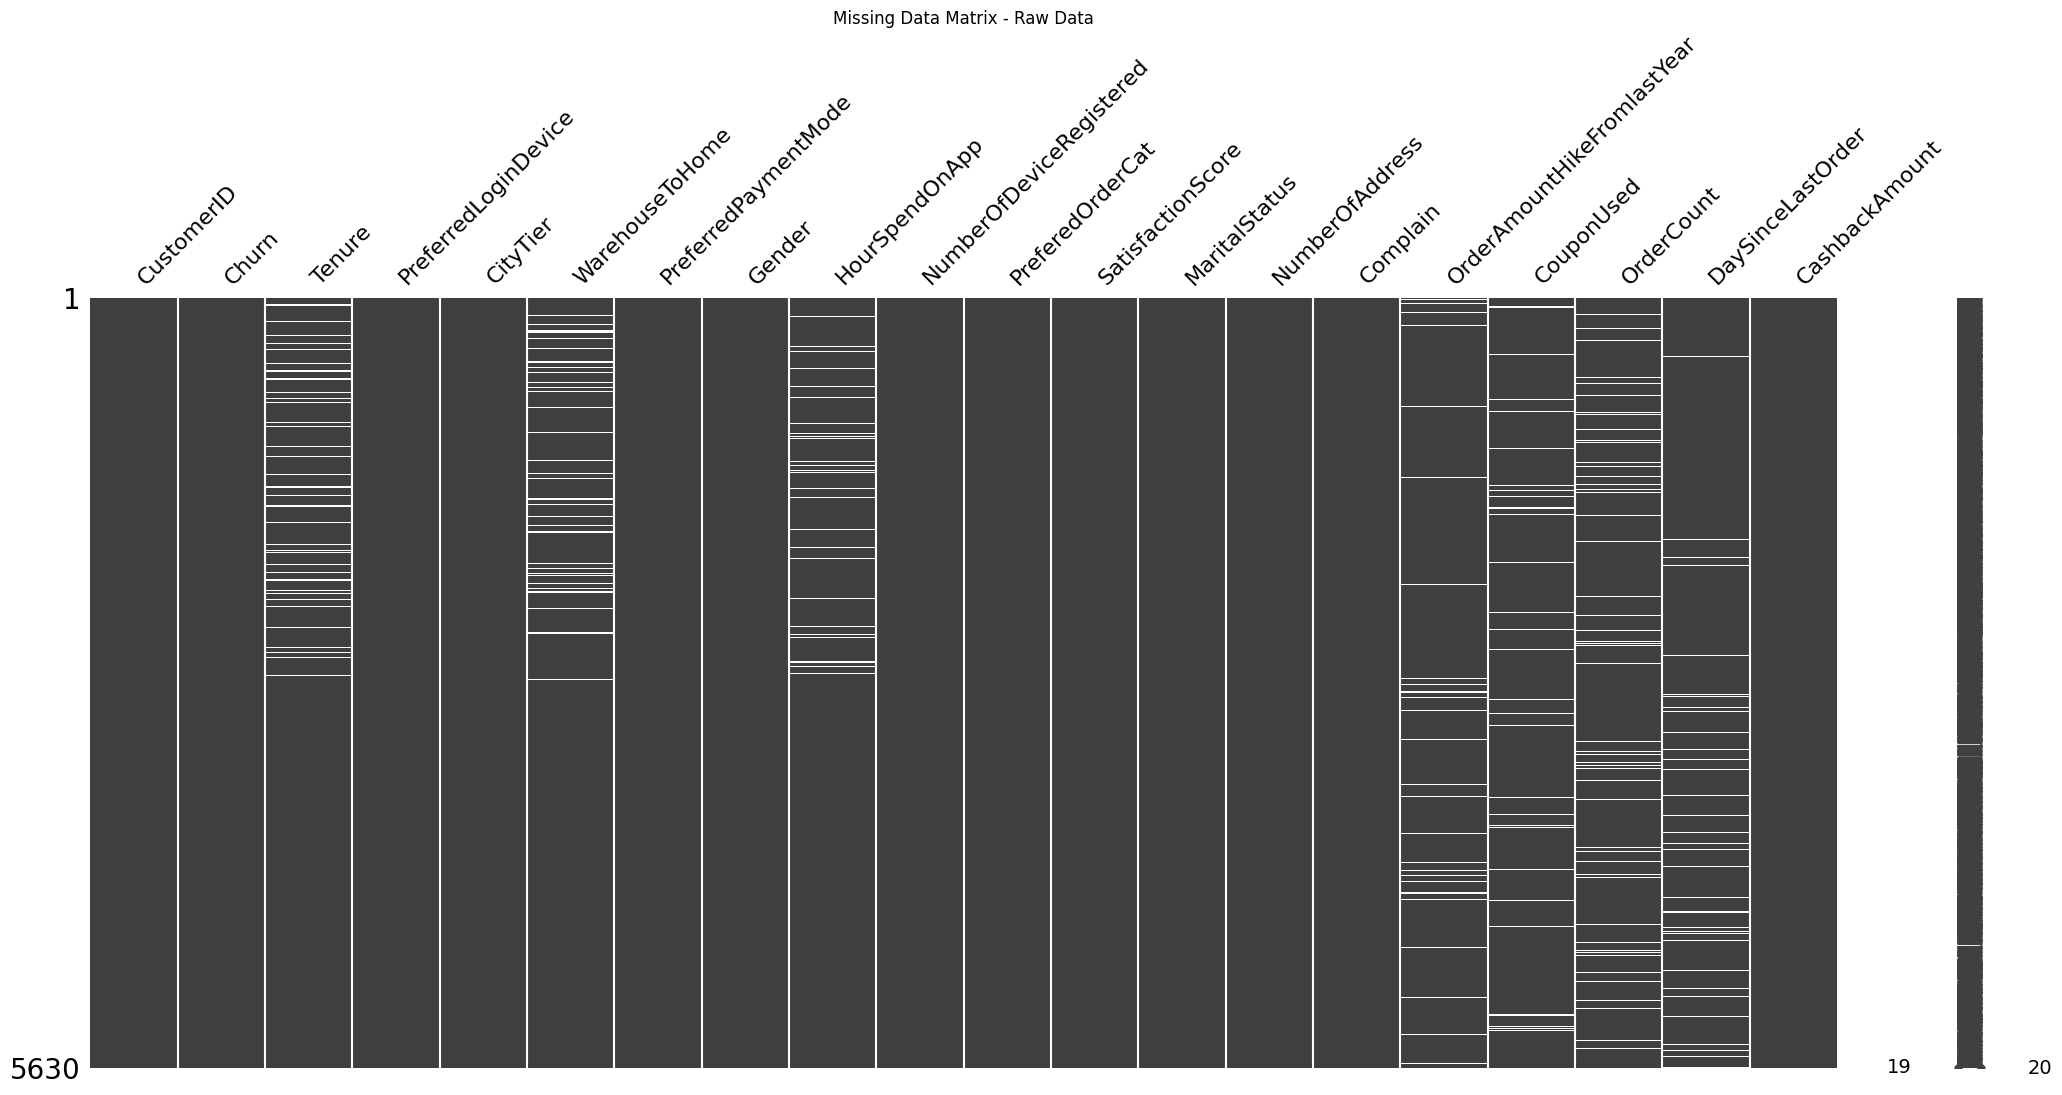

In [ ]:
# Function to visualize missing data patterns
def visualize_missing_data(df, method_name):
    print(f"\n Missing Data Visualization - {method_name}")
    plt.figure(figsize=(10, 6))
    msno.matrix(df)
    plt.title(f"Missing Data Matrix - {method_name}")
    plt.tight_layout()
    plt.show()

# Visualize missing data patterns
visualize_missing_data(df, "Raw Data")

In [ ]:
# Function to analyze missingness patterns in relation to other variables
def analyze_missingness_patterns(df, target_col='Churn'):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            print(f"\n Missing Analysis for: {col}")
            df['Missing_' + col] = df[col].isnull().astype(int)

            if target_col in df.columns:
                print(f"\n Comparing missing values in '{col}' vs mean '{target_col}':")
                print(df.groupby('Missing_' + col)[target_col].mean())

            # Compare with other numerical columns
            for num_col in df.select_dtypes(include='number').columns:
                if num_col != target_col and num_col != 'Missing_' + col:
                    mean_values = df.groupby('Missing_' + col)[num_col].mean()
                    print(f" {num_col} by missing status in {col}:\n{mean_values}")

            # Remove temporary columns
            df.drop(columns=['Missing_' + col], inplace=True)

# Apply the function
analyze_missingness_patterns(df, target_col='Churn')


 Missing Analysis for: Tenure

 Comparing missing values in 'Tenure' vs mean 'Churn':
Missing_Tenure
0    0.161573
1    0.306818
Name: Churn, dtype: float64
 CustomerID by missing status in Tenure:
Missing_Tenure
0    52886.477637
1    51372.825758
Name: CustomerID, dtype: float64
 Tenure by missing status in Tenure:
Missing_Tenure
0    10.189899
1          NaN
Name: Tenure, dtype: float64
 CityTier by missing status in Tenure:
Missing_Tenure
0    1.666045
1    1.424242
Name: CityTier, dtype: float64
 WarehouseToHome by missing status in Tenure:
Missing_Tenure
0    15.697947
1    14.515152
Name: WarehouseToHome, dtype: float64
 HourSpendOnApp by missing status in Tenure:
Missing_Tenure
0    2.955586
1    2.465909
Name: HourSpendOnApp, dtype: float64
 NumberOfDeviceRegistered by missing status in Tenure:
Missing_Tenure
0    3.710399
1    3.253788
Name: NumberOfDeviceRegistered, dtype: float64
 SatisfactionScore by missing status in Tenure:
Missing_Tenure
0    3.058330
1    3.238636
Nam

## 4. Missing Data Imputation Methods
In this section, we'll implement three different imputation methods to handle missing values:


1.   KNN Imputation
2.   Regression Imputation
3. MICE (Multiple Imputation by Chained Equations)




In [ ]:
# 1. KNN Imputation
knn_numeric = df_knn.select_dtypes(include='number')
imputer_knn = KNNImputer(n_neighbors=5)
df_knn[knn_numeric.columns] = imputer_knn.fit_transform(knn_numeric)

In [ ]:
# Calculate the percentage of missing values in each column
missing_percent = df.isnull().mean() * 100
missing_cols = missing_percent[missing_percent > 0].index.tolist()
print("Columns with missing values:", missing_cols)

Columns with missing values: ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']


In [ ]:
# 2. Regression Imputation (manual implementation for each column with missing values)
for col in missing_cols:
    features = df_regression.drop(columns=[col]).select_dtypes(include='number').columns.tolist()

    # Separate rows where the value is not NaN
    df_complete = df_regression[df_regression[col].notna()]
    df_missing = df_regression[df_regression[col].isna()]

    if not df_missing.empty:
        # Temporarily impute other features with their means
        imputer_temp = SimpleImputer(strategy='mean')
        X_train = imputer_temp.fit_transform(df_complete[features])
        y_train = df_complete[col]
        X_missing = imputer_temp.transform(df_missing[features])

        # Train the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict and impute
        predicted = model.predict(X_missing)
        df_regression.loc[df_regression[col].isna(), col] = predicted


In [ ]:
# 3. MICE (Iterative Imputer)
mice_numeric = df_mice.select_dtypes(include='number')
imputer_mice = IterativeImputer(random_state=0)
df_mice[mice_numeric.columns] = imputer_mice.fit_transform(mice_numeric)

In [ ]:
# Display samples after imputation
print("KNN Imputation Sample:\n", df_knn.head())
print("\n Regression Imputation Sample:\n", df_regression.head())
print("\n MICE Imputation Sample:\n", df_mice.head())

KNN Imputation Sample:
    CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0     50001.0    1.0     4.0         Mobile Phone       3.0              6.0   
1     50002.0    1.0     2.6                Phone       1.0              8.0   
2     50003.0    1.0     2.6                Phone       1.0             30.0   
3     50004.0    1.0     0.0                Phone       3.0             15.0   
4     50005.0    1.0     0.0                Phone       1.0             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                       3.0   
1                  UPI    Male             3.0                       4.0   
2           Debit Card    Male             2.0                       4.0   
3           Debit Card    Male             2.0                       4.0   
4                   CC    Male             2.6                       3.0   

     PreferedOrderCat  SatisfactionSco

## 5. Correlation Analysis
Let's analyze the correlation between features and the target variable (Churn) after imputation.

In [ ]:
# Helper function: Get continuous numerical columns only
def get_continuous_numerical(df):
    num_cols = df.select_dtypes(include=np.number).columns
    continuous_cols = [col for col in num_cols if df[col].nunique() > 10]
    return continuous_cols

# Calculate correlation with Churn
def correlation_analysis(df_input, method_name):
    df_corr = df_input.copy()
    df_corr = pd.get_dummies(df_corr, drop_first=True)
    corr_matrix = df_corr.corr()
    churn_corr = corr_matrix['Churn'].sort_values(ascending=False)
    print(f"\n Correlation with Churn - {method_name}:")
    print(churn_corr[1:6])  # Top 5
    return churn_corr

In [ ]:
# Plot correlation with Churn
def plot_churn_correlations(df_input, method_name):
    df_corr = df_input.copy()
    df_corr = pd.get_dummies(df_corr, drop_first=True)
    corr_matrix = df_corr.corr()
   #use comment
    churn_corr = corr_matrix['Churn'].drop('Churn').sort_values(key=lambda x: abs(x), ascending=False)
    top_features = churn_corr[:15]  # Top 15 features

    plt.figure(figsize=(10, 8))
    sns.heatmap(top_features.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)
    plt.title(f'Top Correlations with Churn - {method_name}')
    plt.tight_layout()
    plt.show()


🔍 Correlation with Churn - Regression Imputation:
Complain                         0.250188
MaritalStatus_Single             0.180847
PreferedOrderCat_Mobile Phone    0.154387
PreferedOrderCat_Mobile          0.113364
NumberOfDeviceRegistered         0.107939
Name: Churn, dtype: float64

🔍 Correlation with Churn - MICE Imputation:
Complain                         0.250188
MaritalStatus_Single             0.180847
PreferedOrderCat_Mobile Phone    0.154387
PreferedOrderCat_Mobile          0.113364
NumberOfDeviceRegistered         0.107939
Name: Churn, dtype: float64

🔍 Correlation with Churn - KNN Imputation:
Complain                         0.250188
MaritalStatus_Single             0.180847
PreferedOrderCat_Mobile Phone    0.154387
PreferedOrderCat_Mobile          0.113364
NumberOfDeviceRegistered         0.107939
Name: Churn, dtype: float64


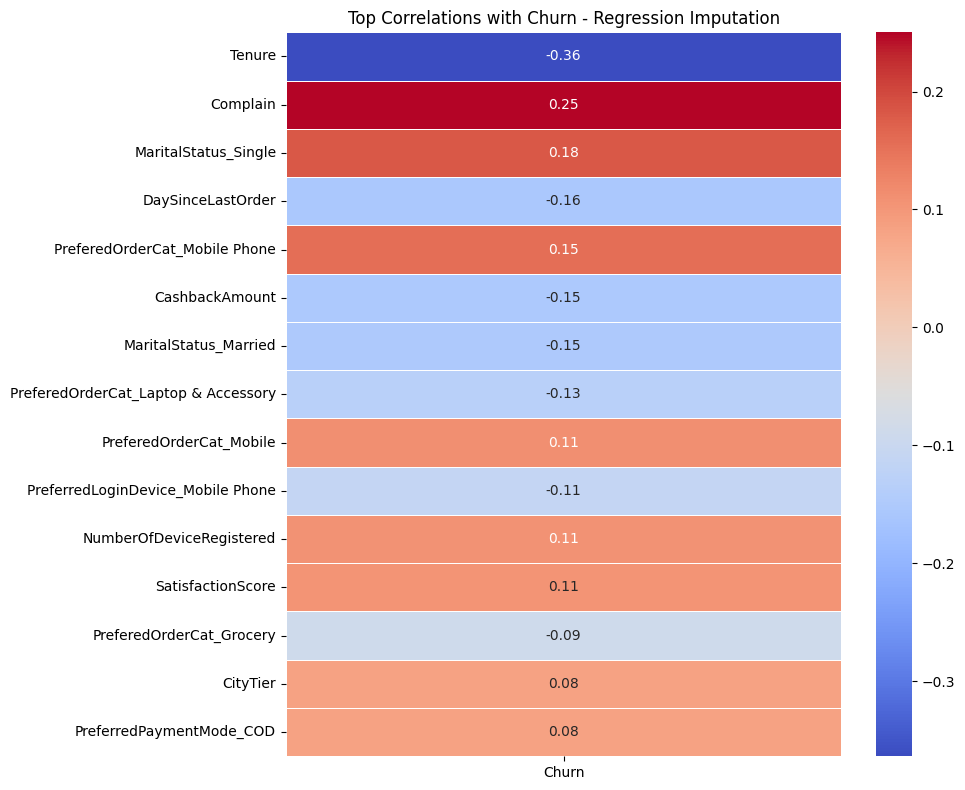

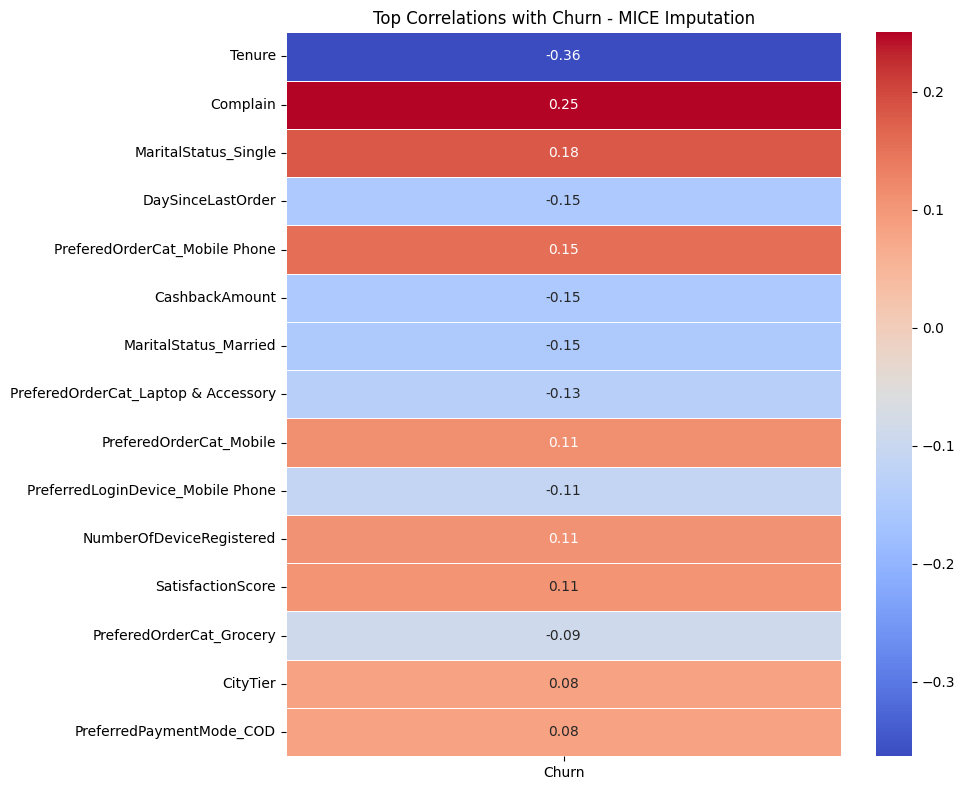

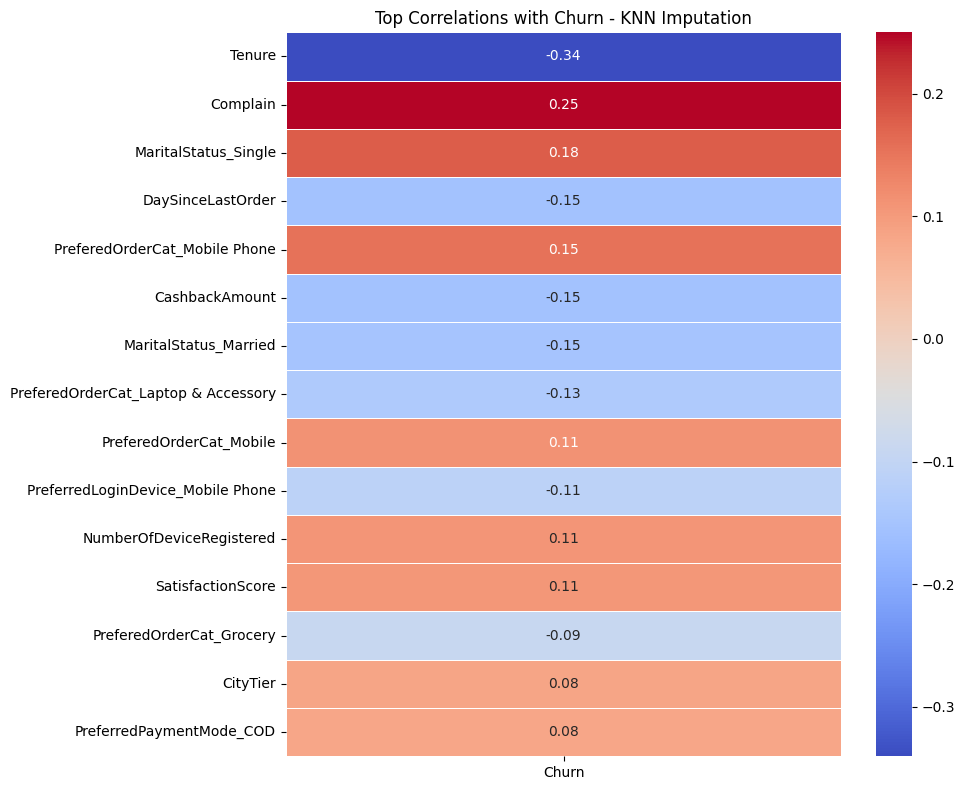

In [ ]:
# Analyze correlations for each imputation method
corr_regression = correlation_analysis(df_regression, "Regression Imputation")
corr_mice = correlation_analysis(df_mice, "MICE Imputation")
corr_knn = correlation_analysis(df_knn, "KNN Imputation")

# Plot correlation matrices
plot_churn_correlations(df_regression, "Regression Imputation")
plot_churn_correlations(df_mice, "MICE Imputation")
plot_churn_correlations(df_knn, "KNN Imputation")

## 6. Outlier Detection and Handling




🔎 Outliers detected using Z-score for Regression Imputation:
 CustomerID                       0
Tenure                           4
WarehouseToHome                  2
HourSpendOnApp                   3
NumberOfAddress                  4
OrderAmountHikeFromlastYear      0
CouponUsed                     112
OrderCount                     185
DaySinceLastOrder               43
CashbackAmount                  13
dtype: int64

🔎 Outliers detected using Z-score for MICE Imputation:
 CustomerID                       0
Tenure                           4
WarehouseToHome                  2
HourSpendOnApp                   3
NumberOfAddress                  4
OrderAmountHikeFromlastYear      0
CouponUsed                     112
OrderCount                     185
DaySinceLastOrder               43
CashbackAmount                  13
dtype: int64

🔎 Outliers detected using Z-score for KNN Imputation:
 CustomerID                       0
Tenure                           4
WarehouseToHome             

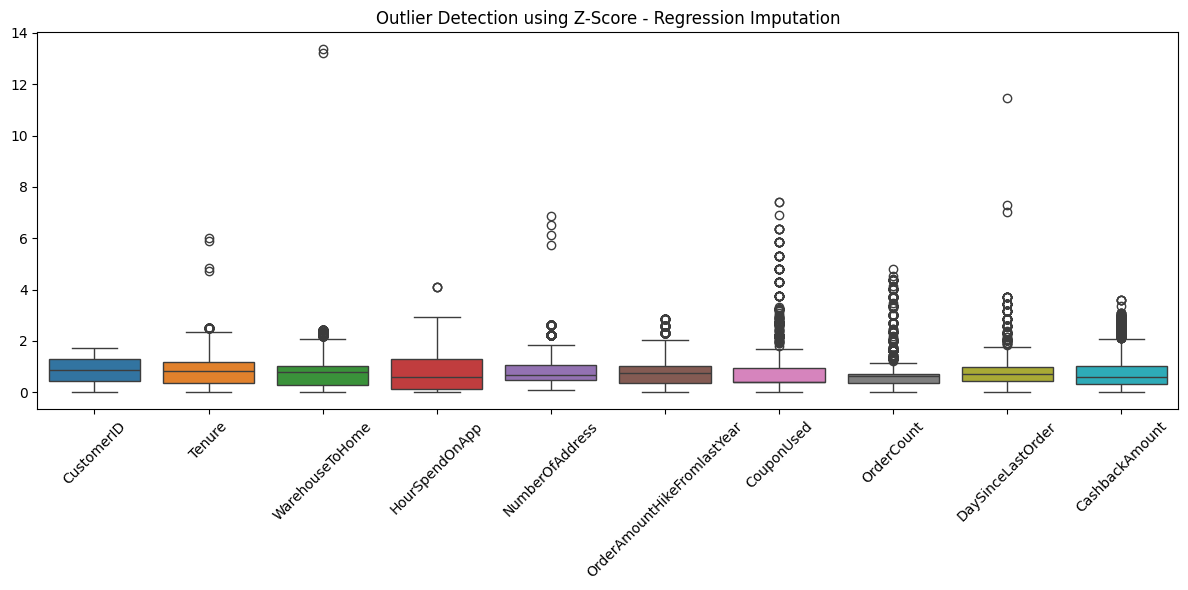

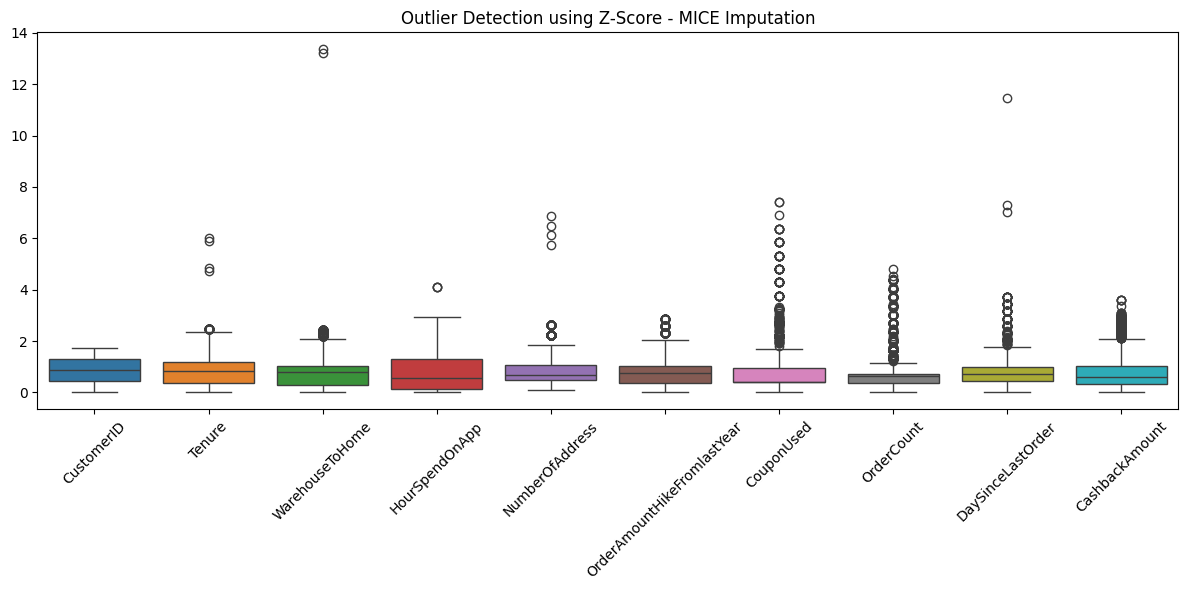

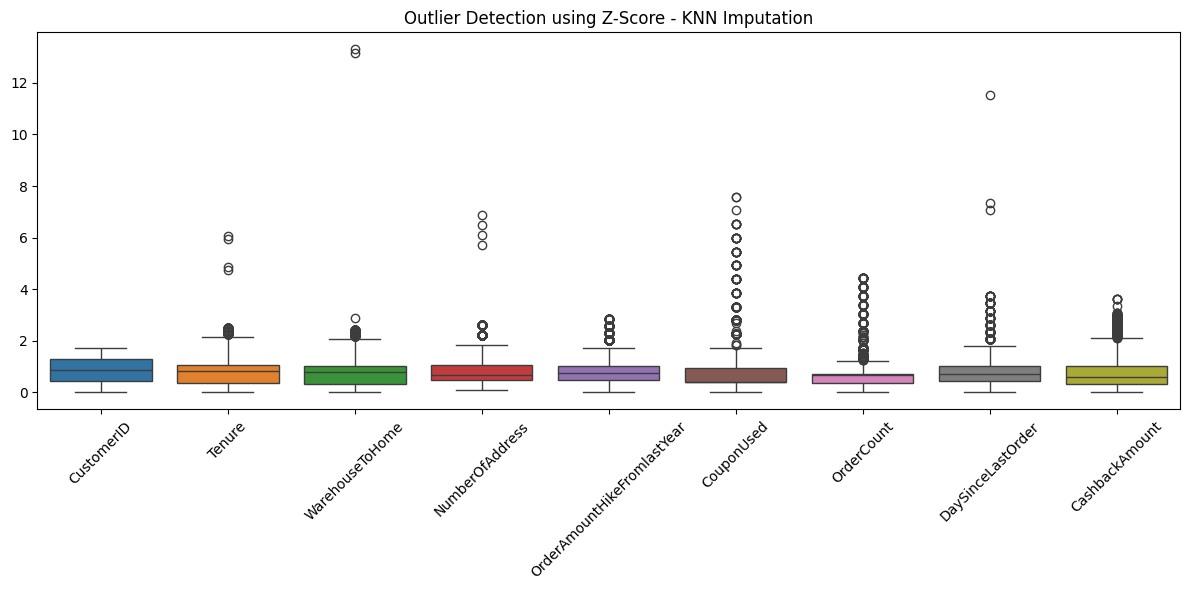

In [ ]:
# Calculate Z-scores to detect outliers
# Detect outliers
def detect_outliers(df_input, method_name):
    cont_cols = get_continuous_numerical(df_input)

    # Z-score method
    z_scores = np.abs((df_input[cont_cols] - df_input[cont_cols].mean()) / df_input[cont_cols].std())
    outliers_z = (z_scores > 3).sum(axis=0)
    print(f"\n Outliers detected using Z-score for {method_name}:\n", outliers_z)
    return outliers_z

# Plot outliers using Z-Score
def plot_outliers_z(df_input, method_name):
    cont_cols = get_continuous_numerical(df_input)
    z_scores = np.abs((df_input[cont_cols] - df_input[cont_cols].mean()) / df_input[cont_cols].std())

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=z_scores)
    plt.xticks(rotation=45)
    plt.title(f'Outlier Detection using Z-Score - {method_name}')
    plt.tight_layout()
    plt.show()


# Run outlier detection
outliers_regression_z = detect_outliers(df_regression, "Regression Imputation")
outliers_mice_z = detect_outliers(df_mice, "MICE Imputation")
outliers_knn_z= detect_outliers(df_knn, "KNN Imputation")

# Plot outliers
plot_outliers_z(df_regression, "Regression Imputation")
plot_outliers_z(df_mice, "MICE Imputation")
plot_outliers_z(df_knn, "KNN Imputation")



In [ ]:
# Calculate Z-scores to detect outliers
# Handle outliers
def handle_outliers(df_input, method_name):
    df = df_input.copy()

    # Keep 'Churn' to avoid changing it
    churn_column = df['Churn']
    df = df.drop('Churn', axis=1)

    # Numerical columns only
    numeric_cols = df.select_dtypes(include=np.number).columns

    # Remove outliers using Z-score
    z_scores = np.abs((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std())
    df = df[(z_scores <= 3).all(axis=1)]  # Remove rows containing outliers

    # Add 'Churn' column back after removing outliers
    df['Churn'] = churn_column[df.index]

    print(f" Handled outliers for {method_name}: Removed {len(df_input) - len(df)} rows ")
    return df

# Apply outlier handling
df_regression_cleaned = handle_outliers(df_regression, "Regression Imputation")
df_mice_cleaned = handle_outliers(df_mice, "MICE Imputation")
df_knn_cleaned = handle_outliers(df_knn, "KNN Imputation")

# Display data after cleaning
print("\nDataFrame shapes after outlier removal:")
print(f"Regression: {df_regression_cleaned.shape}")
print(f"MICE: {df_mice_cleaned.shape}")
print(f"KNN: {df_knn_cleaned.shape}")

 Handled outliers for Regression Imputation: Removed 282 rows 
 Handled outliers for MICE Imputation: Removed 282 rows 
 Handled outliers for KNN Imputation: Removed 282 rows 

DataFrame shapes after outlier removal:
Regression: (5348, 20)
MICE: (5348, 20)
KNN: (5348, 20)


## 7. Feature Selection and Model Preparation


In [ ]:
# Define the most important features based on correlation analysis
top_features = [
    'Tenure',
    'Complain',
    'DaySinceLastOrder',
    'PreferedOrderCat',
    'CashbackAmount',
    'MaritalStatus',
    'PreferredPaymentMode',
    'PreferredLoginDevice',
    'NumberOfDeviceRegistered',
    'SatisfactionScore',
]

# Select top features
def select_top_features(df_input):
    return df_input[top_features + ['Churn']]

# Apply feature selection
df_regression_selected = select_top_features(df_regression_cleaned)
df_mice_selected = select_top_features(df_mice_cleaned)
df_knn_selected = select_top_features(df_knn_cleaned)

# Prepare data for modeling
def prepare_data(df_input):
    df_input = pd.get_dummies(df_input, drop_first=True)
    X = df_input.drop('Churn', axis=1)
    y = df_input['Churn']
    return X, y

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

## 8. Model Training and Evaluation


In [ ]:
# Comprehensive evaluation function
def evaluate_models(X_train, X_test, y_train, y_test, model_dict):
    results = {}
    for model_name, model in model_dict.items():
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results[model_name] = {
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred)
        }

        print(f"{model_name} metrics:")
        for metric, value in results[model_name].items():
            print(f"  - {metric}: {value:.4f}")
    return results

# Run evaluations for all datasets
def run_all_evaluations(df, label):
    print(f"\n=== Evaluating models with {label} imputation ===")
    X, y = prepare_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return evaluate_models(X_train, X_test, y_train, y_test, models)

# Apply evaluation to each dataset
results_regression = run_all_evaluations(df_regression_selected, "Regression")
results_mice = run_all_evaluations(df_mice_selected, "MICE")
results_knn = run_all_evaluations(df_knn_selected, "KNN")


=== Evaluating models with Regression imputation ===
Training Logistic Regression...
Logistic Regression metrics:
  - Accuracy: 0.8860
  - Precision: 0.7188
  - Recall: 0.5169
  - F1 Score: 0.6013
Training Random Forest...
Random Forest metrics:
  - Accuracy: 0.9542
  - Precision: 0.9161
  - Recall: 0.7978
  - F1 Score: 0.8529
Training Gradient Boosting...
Gradient Boosting metrics:
  - Accuracy: 0.9047
  - Precision: 0.7754
  - Recall: 0.6011
  - F1 Score: 0.6772

=== Evaluating models with MICE imputation ===
Training Logistic Regression...
Logistic Regression metrics:
  - Accuracy: 0.8869
  - Precision: 0.7244
  - Recall: 0.5169
  - F1 Score: 0.6033
Training Random Forest...
Random Forest metrics:
  - Accuracy: 0.9514
  - Precision: 0.9200
  - Recall: 0.7753
  - F1 Score: 0.8415
Training Gradient Boosting...
Gradient Boosting metrics:
  - Accuracy: 0.9056
  - Precision: 0.7730
  - Recall: 0.6124
  - F1 Score: 0.6834

=== Evaluating models with KNN imputation ===
Training Logistic R

## 9. Results Comparison and Visualization


In [ ]:
# Combine results into a structured DataFrame
combined_results = []
for model_name in models.keys():
    combined_results.append({
        "Model": model_name,
        "Imputation": "Regression",
        **results_regression[model_name]
    })
    combined_results.append({
        "Model": model_name,
        "Imputation": "MICE",
        **results_mice[model_name]
    })
    combined_results.append({
        "Model": model_name,
        "Imputation": "KNN",
        **results_knn[model_name]
    })

df_results = pd.DataFrame(combined_results)

# Display results table
print("\n=== Model Performance Comparison ===")
display(df_results)

# Save results to CSV
df_results.to_csv("model_metrics_results.csv", index=False)


=== Model Performance Comparison ===


,Model,Imputation,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,Regression,0.885981,0.718750,0.516854,0.601307
1,Logistic Regression,MICE,0.886916,0.724409,0.516854,0.603279
2,Logistic Regression,KNN,0.878505,0.700000,0.471910,0.563758
3,Random Forest,Regression,0.954206,0.916129,0.797753,0.852853
4,Random Forest,MICE,0.951402,0.920000,0.775281,0.841463
5,Random Forest,KNN,0.956075,0.922581,0.803371,0.858859
6,Gradient Boosting,Regression,0.904673,0.775362,0.601124,0.677215
7,Gradient Boosting,MICE,0.905607,0.773050,0.612360,0.683386
8,Gradient Boosting,KNN,0.896262,0.744526,0.573034,0.647619


<Figure size 1400x800 with 0 Axes>

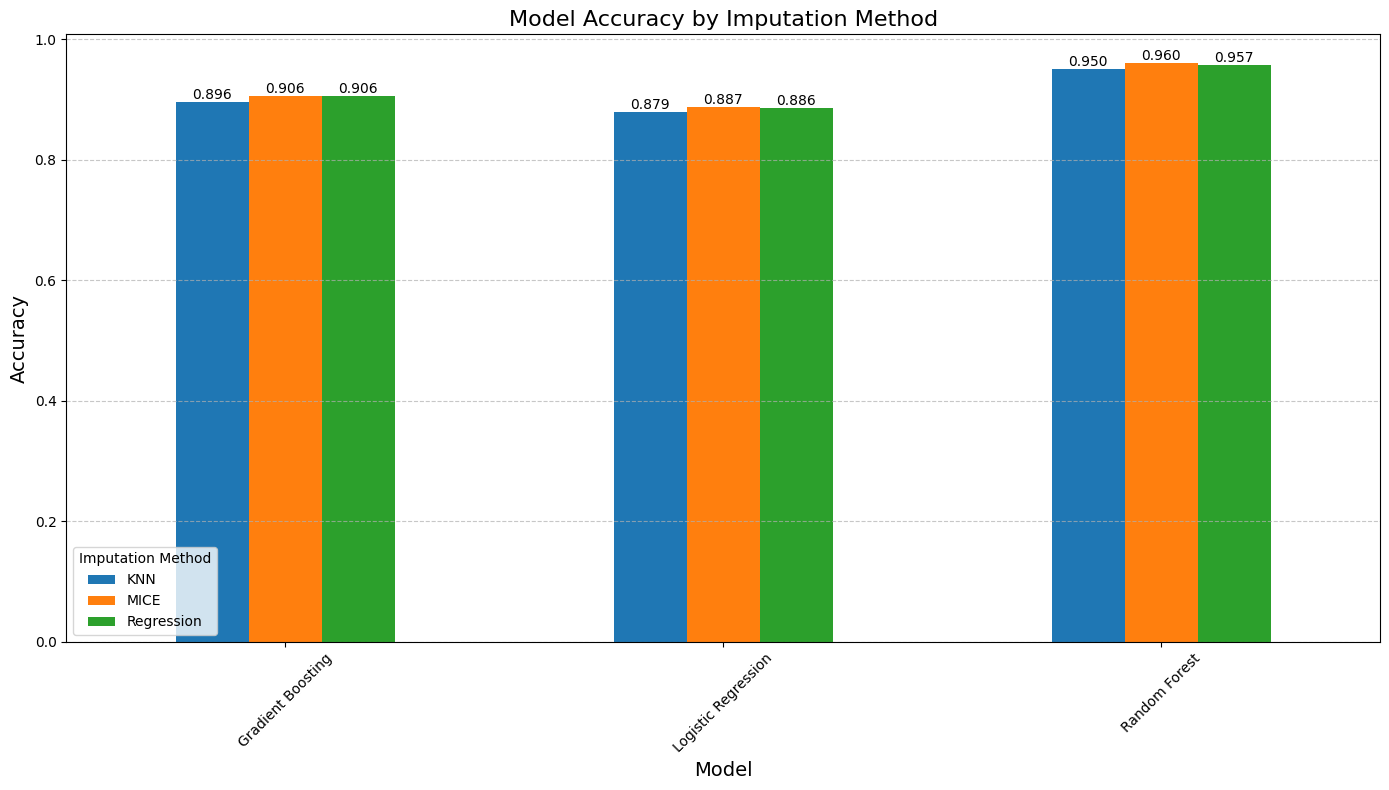

<Figure size 1400x800 with 0 Axes>

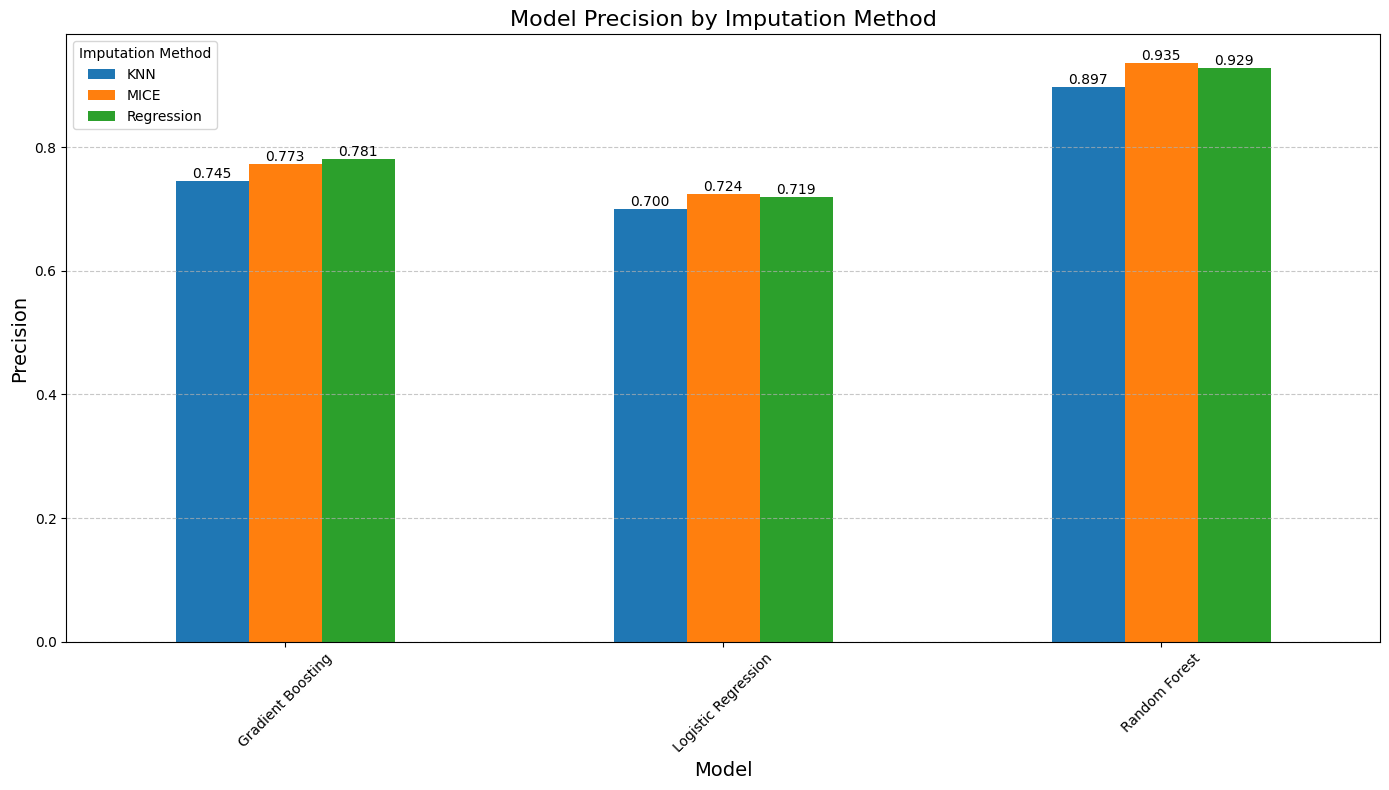

<Figure size 1400x800 with 0 Axes>

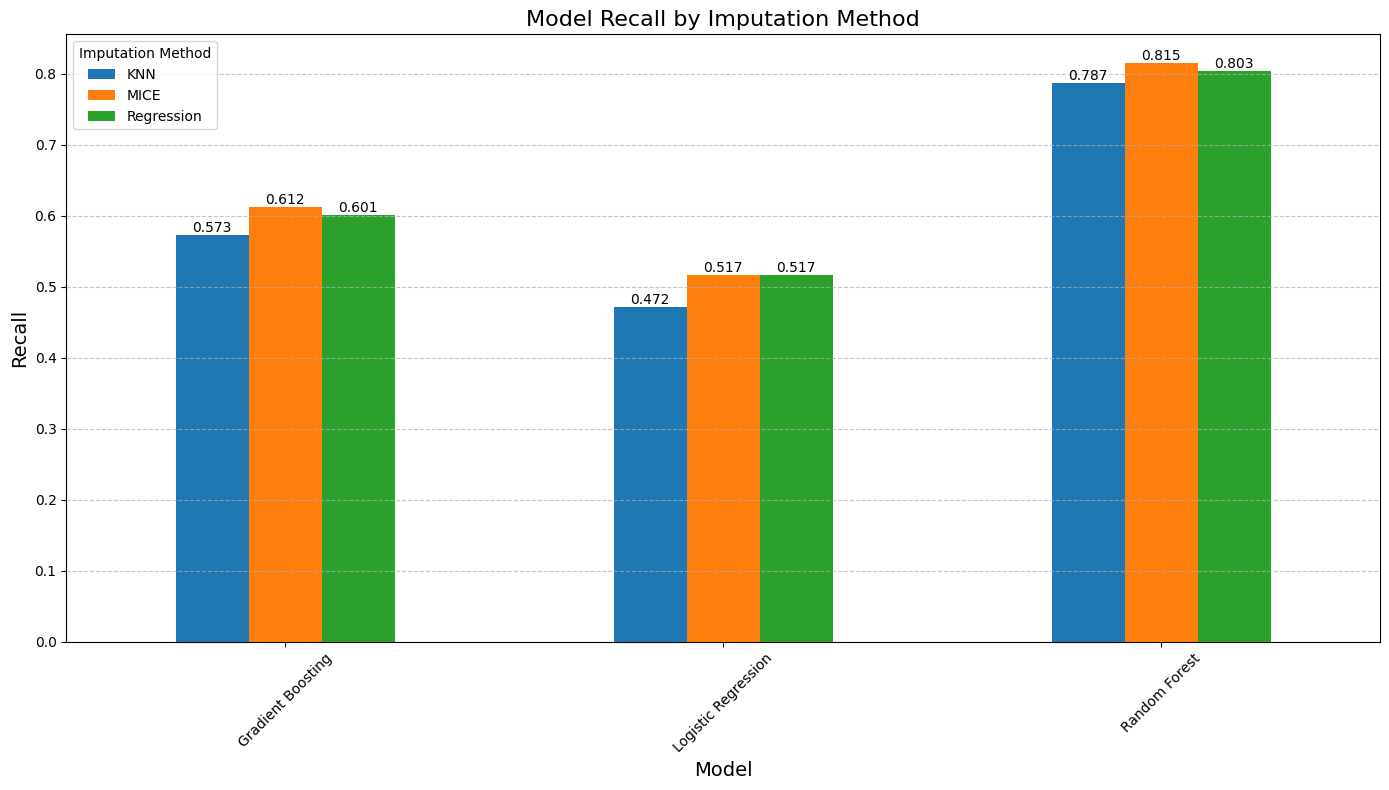

<Figure size 1400x800 with 0 Axes>

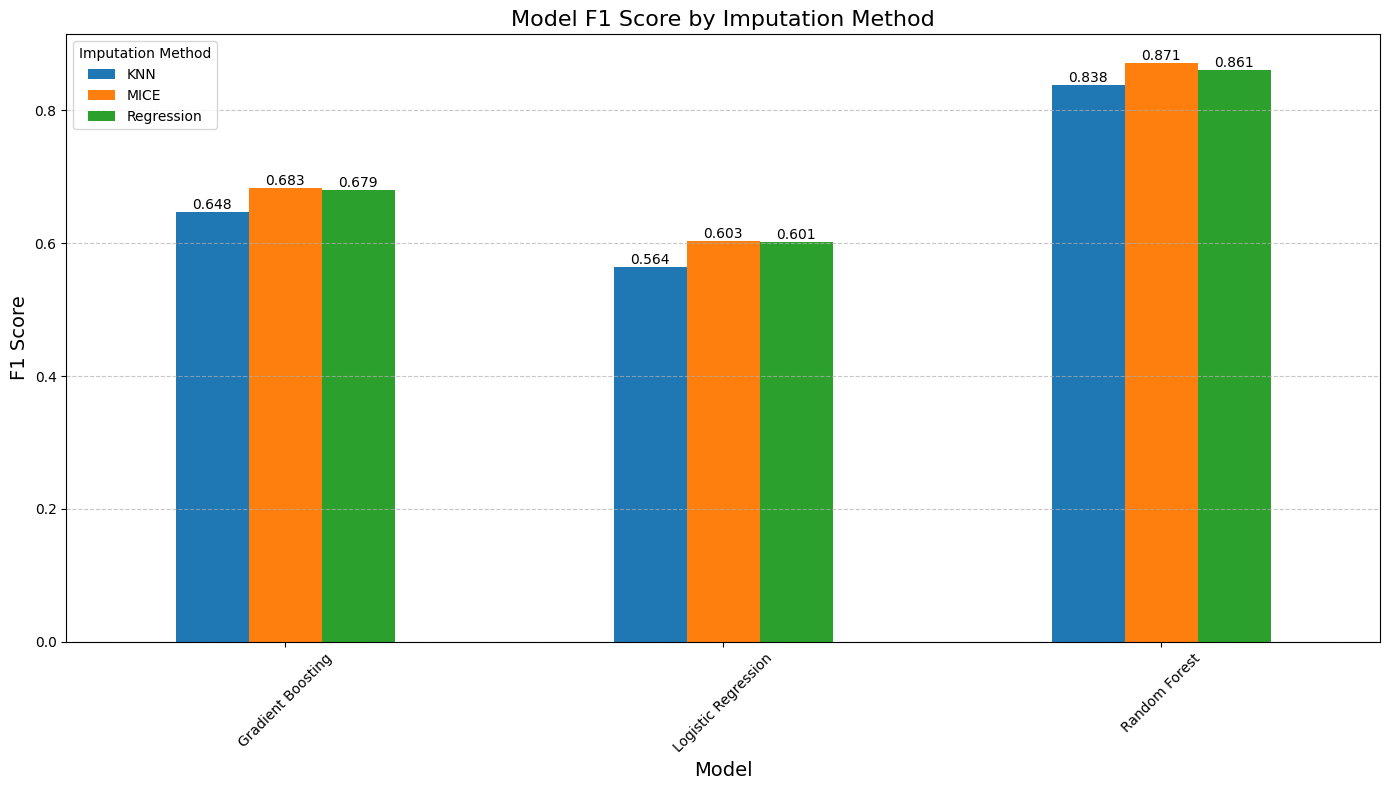

In [ ]:
# Create a comprehensive visualization of model performance
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

for metric in metrics:
    plt.figure(figsize=(14, 8))

    # Reshape data for grouped bar chart
    pivot_data = df_results.pivot(index='Model', columns='Imputation', values=metric)

    # Plot grouped bar chart
    ax = pivot_data.plot(kind='bar', figsize=(14, 8))

    plt.title(f'Model {metric} by Imputation Method', fontsize=16)
    plt.ylabel(metric, fontsize=14)
    plt.xlabel('Model', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Imputation Method')

    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=10)

    plt.tight_layout()
    plt.show()

## 10. Save Processed Datasets


In [ ]:
# Save cleaned datasets
df_knn_cleaned.to_csv("df_knn_cleaned.csv", index=False)
df_mice_cleaned.to_csv("df_mice_cleaned.csv", index=False)
df_regression_cleaned.to_csv("df_regression_cleaned.csv", index=False)

In [ ]:
# Function to get continuous numeric columns
def get_continuous_numerical(df):
    # Return only columns with numeric (continuous) values
    return df.select_dtypes(include='number').columns.tolist()

# Count missing values for each column
missing_counts = df.isnull().sum()

# Detect outliers using Z-score method
z_scores = np.abs((df[get_continuous_numerical(df)] - df[get_continuous_numerical(df)].mean()) /
                  df[get_continuous_numerical(df)].std())
outlier_counts = (z_scores > 3).sum()  # Count how many values in each column exceed Z = 3

# Combine both missing and outlier counts into a single DataFrame
summary_df = pd.DataFrame({
    'Column': df.columns,
    'MissingValues': missing_counts,
    'OutlierCount': df.columns.map(lambda col: outlier_counts[col] if col in outlier_counts else 0)
})

# Save to a CSV file for reporting
summary_df.to_csv('missing_outlier_summary.csv', index=False)